In [46]:
import numpy as np
import pandas as pd
import networkx as nx
import random

import torch_geometric.utils
import torch

import seaborn as sns
import pickle

from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle

### Laod Exp data

In [42]:
exp_df = pd.read_pickle("./data/exp/tcga_brca_mRNAseq_RSEM_normalized_log2_preprocessed.pkl")
gene_list = exp_df.index.tolist()
sample_list = exp_df.columns.tolist()
exp_df

,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5L-AAT1-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
A1BG,7.622709,7.891081,8.725321,7.577563,8.070823,7.670811,7.723120,8.295466,5.620563,7.152768,...,5.464476,8.330807,10.011307,9.058093,6.904613,8.880456,7.802326,7.995115,8.779859,7.956098
A2BP1,0.000000,0.000000,0.000000,0.000000,1.937269,-0.769551,0.000000,-0.935117,2.171527,-1.595969,...,0.000000,0.000000,-0.699466,2.384243,2.242420,0.000000,-1.344831,0.502942,-0.743472,0.000000
A2LD1,6.685988,6.146993,7.333247,5.965950,7.270250,6.801358,6.672033,7.868015,5.243981,6.063136,...,7.561177,7.814384,6.967875,5.900026,8.285672,5.947919,7.035935,6.320649,6.345201,4.654584
A2ML1,0.463204,2.121082,0.000000,0.726744,1.767358,0.230449,2.026800,0.000000,1.656954,2.927707,...,7.167120,0.000000,4.001064,0.509747,0.000000,2.703987,-1.344831,5.800623,1.256588,2.062018
A2M,12.501433,12.886455,13.109896,13.419989,13.226629,13.590040,13.911263,11.635938,14.948867,14.538279,...,12.181168,11.785606,12.975046,14.161525,13.225956,12.401229,14.312653,14.061273,15.168928,12.841401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,10.238851,9.237422,9.055784,9.246419,9.599438,9.291136,9.004073,8.329360,10.414229,9.761690,...,8.920820,9.127567,8.572085,9.060519,7.857118,8.300173,9.426661,9.544600,8.982789,9.163566
ZYX,11.776124,12.426428,12.414355,12.474556,11.980747,12.012619,12.109208,11.653632,12.594962,11.797529,...,12.023580,12.449682,12.655835,12.438414,12.704740,13.416940,12.321395,12.419318,12.704688,11.732389
ZZEF1,10.887932,10.364848,9.880935,9.609426,9.700292,9.848825,10.463088,10.122909,10.915356,10.320764,...,10.278893,9.072401,9.546174,9.921989,9.125051,9.645031,10.917266,10.489257,9.559210,9.140624
ZZZ3,10.205129,8.667973,8.992994,9.453001,9.784147,10.052214,9.151948,8.784306,10.488039,10.223519,...,8.278894,8.593938,8.246066,9.766374,8.165240,8.791446,9.388187,9.897404,9.552340,8.852105


### Load Label dict

,Subtype,Subtype_index
TCGA-3C-AAAU-01,LumB,1
TCGA-3C-AALI-01,Her2,2
TCGA-3C-AALJ-01,LumB,1
TCGA-3C-AALK-01,LumA,0
TCGA-4H-AAAK-01,LumA,0
...,...,...
TCGA-WT-AB44-01,LumA,0
TCGA-XX-A899-01,LumA,0
TCGA-XX-A89A-01,LumA,0
TCGA-Z7-A8R5-01,LumA,0


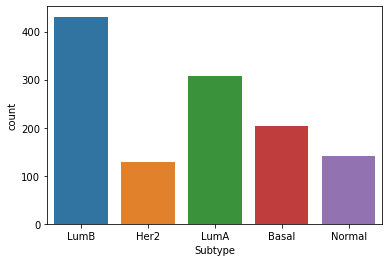

In [22]:
label_mapping = {"LumA":0 , "LumB":1 , "Her2":2, "Basal":3, "Normal":4}
label_num = len(label_mapping)
label_df = pd.read_csv("./data/exp/tcga_brca_pam50_refine.csv",index_col=0)
sns.countplot(x='Subtype', data=label_df)
label_df['Subtype_index'] = list(map(lambda x:label_mapping[x],label_df['Subtype']))
label_dict = dict(zip(label_df.index, label_df['Subtype_index']))
label_num
#label_dict
label_df

### Load Network data

In [22]:
network_file = "./data/network/omnipath/omnipath_webservice_interactions__recent.tsv"
network_df = pd.read_csv(network_file,sep="\t")
network_df= network_df[np.logical_and(network_df['source_genesymbol'].isin(gene_list),network_df['target_genesymbol'].isin(gene_list))]
network_df = network_df[['source_genesymbol','target_genesymbol','type']]
print(len(network_df['source_genesymbol'].unique()))
print(len(network_df['target_genesymbol'].unique()))
#print(len(network_df.unique()))
network_df

6652
8722


/home/minjae/miniconda3/envs/minjae/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (12,19,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,source_genesymbol,target_genesymbol,type
0,UBC,VCP,PPI
1,UBC,GRIN1,PPI
2,UBC,TGM2,PPI
3,UBC,ITPR3,PPI
4,UBC,FAF1,PPI
...,...,...,...
236530,MSC,MCM7,TF
236531,STAT2,IRF7,TF
236533,GLI2,ILF3,TF
236535,GLI2,IGFBP3,TF


In [23]:
set(network_df['type'])

{'PPI', 'TF'}

In [24]:
network_file_ptms = "./data/network/omnipath/omnipath_webservice_ptms__recent.tsv"
network_ptms = pd.read_csv(network_file_ptms,sep="\t")
network_ptms

,enzyme,substrate,enzyme_genesymbol,substrate_genesymbol,isoforms,residue_type,residue_offset,modification,sources,references,ncbi_tax_id
0,Q13177,P01236,PAK2,PRL,1,S,207,phosphorylation,MIMP;PhosphoSite;Signor;phosphoELM,11943200,9606
1,Q9BQI3,P05198,EIF2AK1,EIF2S1,1,S,52,phosphorylation,HPRD;MIMP;PhosphoNetworks;PhosphoSite;Signor;p...,10542257;1677563;3352609;9819435,9606
2,Q9BQI3,P05198,EIF2AK1,EIF2S1,1,S,49,phosphorylation,MIMP;PhosphoNetworks;PhosphoSite;Signor;phosph...,3352609,9606
3,Q9BQI3,P05198,EIF2AK1,EIF2S1,1,S,58,phosphorylation,PhosphoNetworks,NaN,9606
4,Q05655,Q9UQL6,PRKCD,HDAC5,1;2,S,259,phosphorylation,PhosphoSite,NaN,9606
...,...,...,...,...,...,...,...,...,...,...,...
51170,P68403,P31232,Prkcb,Tagln,1,S,181,phosphorylation,MIMP,NaN,10116
51171,P63319,P31232,Prkcg,Tagln,1,S,181,phosphorylation,MIMP,NaN,10116
51172,P09216,P31232,Prkce,Tagln,1,S,181,phosphorylation,MIMP,NaN,10116
51173,P63319,P15431,Prkcg,Gabrb1,1,S,434,phosphorylation,MIMP,NaN,10116


In [25]:
nodes = list(set(list(network_df['source_genesymbol'])) | set(list(network_df['target_genesymbol'])))
nodes_mapping = dict(zip(np.sort(nodes),list(range(len(nodes)))))
network_df['source_geneid'] = list(map(lambda x:nodes_mapping[x],network_df['source_genesymbol']))
network_df['target_geneid'] = list(map(lambda x:nodes_mapping[x],network_df['target_genesymbol']))
network_df


,source_genesymbol,target_genesymbol,type,source_geneid,target_geneid
0,UBC,VCP,PPI,8997,9195
1,UBC,GRIN1,PPI,8997,3375
2,UBC,TGM2,PPI,8997,8497
3,UBC,ITPR3,PPI,8997,4095
4,UBC,FAF1,PPI,8997,2728
...,...,...,...,...,...
236530,MSC,MCM7,TF,5043,4816
236531,STAT2,IRF7,TF,8158,4031
236533,GLI2,ILF3,TF,3205,3958
236535,GLI2,IGFBP3,TF,3205,3870


In [26]:
len(nodes)

9630

In [37]:
edges = list(zip(network_df['source_geneid'],network_df['target_geneid']))
G = nx.Graph(edges).to_directed()
edge_index = []
for e1,e2 in G.edges:
    edge_index.append([e1,e2])
edge_index = torch.tensor(edge_index).t().contiguous()
print(edges[0])
#print(edge_index.shape)
len(nodes)

(8997, 9195)


9630

In [36]:
len(list(set(nodes).intersection(set(gene_list))))

9630

### Filtering genes with network nodes 

In [31]:
exp_df = exp_df.loc[nodes,:]
exp_df.index = list(map(lambda x:nodes_mapping[x], exp_df.index))
exp_df = exp_df.loc[range(len(nodes)),:]
exp_df
#Random shuffle nodes
# shuffle_nodes  = nodes[:]
# random.shuffle(shuffle_nodes)

# exp_df = exp_df.loc[shuffle_nodes,:]
# exp_df.index = list(map(lambda x:nodes_mapping[x], exp_df.index))

NameError: name 'exp_df' is not defined

### Torch Dataset

In [47]:
with open('netics_ori_exp.pkl','rb') as f:
    ori_exp = pickle.load(f)

In [48]:
ori_exp

,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,TCGA-A1-A0SF-01,TCGA-A1-A0SG-01,TCGA-A1-A0SH-01,TCGA-A1-A0SI-01,TCGA-A1-A0SJ-01,TCGA-A1-A0SK-01,TCGA-A1-A0SM-01,...,TCGA-OL-A5RY-01,TCGA-OL-A5RZ-01,TCGA-OL-A5S0-01,TCGA-OL-A66H-01,TCGA-OL-A66I-01,TCGA-OL-A66J-01,TCGA-OL-A66K-01,TCGA-PE-A5DC-01,TCGA-PE-A5DD-01,TCGA-PE-A5DE-01
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,14.948912,14.538340,13.941184,13.927870,13.606635,13.773022,13.261198,14.432732,12.033201,13.129526,...,13.953547,11.877640,13.777746,13.426439,15.344069,13.786688,12.865303,13.704505,13.890768,13.920723
2,9.477337,9.045308,9.316159,9.975079,9.491707,9.036263,9.285433,8.988673,9.988866,8.686447,...,9.056910,9.584496,9.247375,9.681707,9.041171,9.781728,9.315610,10.155043,10.292873,9.702751
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,9.846231,10.373893,10.539918,10.523277,9.914519,10.355547,9.555211,10.909893,10.744385,10.292139,...,9.822872,9.682047,11.723473,10.554511,10.244237,10.060286,10.755296,10.924270,9.936822,9.949514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6011,9.266632,8.525701,8.527142,8.954878,8.933115,8.241089,9.551255,8.554369,10.799253,8.276254,...,8.700033,8.431479,8.495470,8.621420,9.071702,8.007990,8.833151,8.342697,8.070886,8.758744
6012,8.894106,8.544754,8.789664,8.066679,8.345444,8.655343,8.279951,8.475020,10.166047,8.968249,...,8.574323,9.260273,9.168081,8.301856,8.779561,8.423698,8.122525,8.792505,8.138172,8.587173
6013,8.331845,9.343734,9.665087,9.404881,9.139668,8.440227,10.720237,8.719962,10.728126,8.983138,...,9.691199,10.238597,10.258777,9.070650,8.915889,8.864416,8.092170,10.405228,9.803557,9.063034
6014,12.595195,11.797934,11.554980,12.383833,11.512063,12.416260,12.140927,11.566577,9.210035,12.158318,...,12.432412,11.903573,12.967609,12.023917,12.693090,12.349216,12.276868,12.126246,11.781517,12.154033


In [17]:
with open('pagerank_exp_data.pkl','rb') as f:
    data = pickle.load(f)

In [19]:
data

,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,TCGA-A1-A0SF-01,TCGA-A1-A0SG-01,TCGA-A1-A0SH-01,TCGA-A1-A0SI-01,TCGA-A1-A0SJ-01,TCGA-A1-A0SK-01,TCGA-A1-A0SM-01,...,TCGA-OL-A5RY-01,TCGA-OL-A5RZ-01,TCGA-OL-A5S0-01,TCGA-OL-A66H-01,TCGA-OL-A66I-01,TCGA-OL-A66J-01,TCGA-OL-A66K-01,TCGA-PE-A5DC-01,TCGA-PE-A5DD-01,TCGA-PE-A5DE-01
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.499840,1.083664,0.478357,0.464861,0.139242,0.307900,-0.210910,0.976614,-1.455666,-0.344379,...,0.490889,-1.613351,0.312689,-0.043413,1.900389,0.321752,-0.612208,0.238448,0.427253,0.457617
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6011,0.686628,-0.615321,-0.612789,0.138820,0.100578,-1.115437,1.186762,-0.564946,3.379720,-1.053646,...,-0.308989,-0.780887,-0.668443,-0.447127,0.344100,-1.525033,-0.075077,-0.936894,-1.414514,-0.205823
6012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [49]:
sample_shffuled_list = shuffle(ori_exp.T,random_state=1).T
#sample_shffuled_list

In [50]:
sample_shffuled_list

,TCGA-D8-A145-01,TCGA-D8-A27I-01,TCGA-GM-A2DI-01,TCGA-A1-A0SI-01,TCGA-LL-A5YM-01,TCGA-B6-A0RV-01,TCGA-OL-A5D7-01,TCGA-B6-A0WY-01,TCGA-AO-A1KP-01,TCGA-AR-A2LJ-01,...,TCGA-OK-A5Q2-01,TCGA-E9-A1R6-01,TCGA-C8-A1HI-01,TCGA-D8-A1XW-01,TCGA-EW-A1P5-01,TCGA-E2-A158-01,TCGA-A2-A0YF-01,TCGA-EW-A1P8-01,TCGA-AC-A23E-01,TCGA-A2-A0D0-01
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,14.306724,14.637424,14.132867,13.261198,12.987386,13.760468,12.111230,16.567200,11.502014,14.396544,...,14.186437,12.170899,14.408980,14.900677,12.417851,13.277072,14.038032,12.888080,13.851055,16.779206
2,9.441094,9.315733,9.176252,9.285433,10.437025,9.393114,10.041224,9.558805,9.840980,9.904259,...,9.598162,10.071341,9.781166,8.461545,9.869184,8.375374,7.696476,8.921457,9.472210,9.578545
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,9.783236,10.046898,9.667999,9.555211,11.996323,9.417989,11.173331,10.570051,9.945583,10.576725,...,10.461767,10.763034,10.467722,9.845675,10.623748,9.638108,9.844191,10.177406,10.258673,11.161212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6011,8.959340,8.523360,8.917655,9.551255,8.049388,8.139799,8.432637,8.592768,9.246603,8.151987,...,8.270163,8.929962,8.848266,10.324708,8.421507,8.797127,8.797475,10.264480,9.175409,9.321471
6012,8.504682,8.531212,8.778644,8.279951,8.109174,9.000625,8.804907,8.716601,9.217449,7.997388,...,8.633529,8.575174,8.014583,9.065108,8.898452,8.688677,9.037278,8.934948,8.111183,9.784832
6013,8.385143,5.700592,8.758097,10.720237,9.043880,10.010167,10.341386,8.727428,9.881607,8.798491,...,9.884301,9.695041,8.422622,8.350201,8.904356,8.881322,9.133332,10.810845,8.702066,9.763552
6014,11.363355,11.964252,12.170606,12.140927,12.404736,11.234257,12.152572,12.185250,11.135735,13.204223,...,12.491147,10.715302,11.509831,11.757009,11.793242,12.809732,11.476795,12.571945,11.938881,13.042401


In [51]:
data_list = []
for sample in sample_shffuled_list:
    
    sample_exp = ori_exp[sample]
    sample_exp = sample_exp.values
    
    x = torch.tensor(sample_exp,dtype=torch.float)
    x = torch.unsqueeze(x,1)
    y = torch.LongTensor([label_dict[sample]]) 
    #print(y)
    GNNData = Data(x=x,y=y)
#    GNNData.__setitem__('sample',sample)
    data_list.append(GNNData)


In [52]:
kf = KFold(n_splits=10,shuffle=False)
train_index_list = []
test_index_list = []
for train_index, test_index in kf.split(range(len(data_list))):
    train_index_list.append(train_index)
    test_index_list.append(test_index)

In [37]:
#Not shuffle
i = 0
for train_index, test_index in zip(train_index_list,test_index_list):
    train_data_list = []
    for train_idx in train_index:
        train_data_list.append(data_list[train_idx])
    
    test_data_list = []
    for test_idx in test_index:
        test_data_list.append(data_list[test_idx])
        
    f = open("./data/preprocessed/cv/tcga_brca_dataset_train_{}.pkl".format(i),'wb')
    pickle.dump(train_data_list, f)
    f.close()

    f = open("./data/preprocessed/cv/tcga_brca_dataset_test_{}.pkl".format(i),'wb')
    pickle.dump(test_data_list, f)
    f.close()
    
    i = i+1

In [44]:
#Shuffle
i = 0
for train_index, test_index in zip(train_index_list,test_index_list):
    train_data_list = []
    for train_idx in train_index:
        train_data_list.append(data_list[train_idx])
    
    test_data_list = []
    for test_idx in test_index:
        test_data_list.append(data_list[test_idx])
        
    f = open("./data/preprocessed/cv_node_shuffle/tcga_brca_dataset_train_{}.pkl".format(i),'wb')
    pickle.dump(train_data_list, f)
    f.close()

    f = open("./data/preprocessed/cv_node_shuffle/tcga_brca_dataset_test_{}.pkl".format(i),'wb')
    pickle.dump(test_data_list, f)
    f.close()
    
    i = i+1

### Save

In [55]:
f = open("./data/preprocessed/tcga_brca_gene_mapping.pkl",'wb')
pickle.dump(nodes_mapping, f)
f.close()

In [56]:
f = open("./data/preprocessed/tcga_brca_edge_index.pkl",'wb')
pickle.dump(edge_index, f)
f.close()

In [4]:
with open("./data/preprocessed/tcga_brca_edge_index.pkl",'rb') as f:
    edgein = pickle.load(f)
edgein

tensor([[8997, 8997, 8997,  ..., 6565, 2036, 3200],
        [9195, 3375, 8497,  ..., 1878, 3204, 8413]])

In [58]:
exp_df.to_pickle("./data/preprocessed/tcga_brca_exp.pkl")

In [59]:
f = open("./data/preprocessed/tcga_brca_dataset.pkl",'wb')
pickle.dump(data_list, f)
f.close()

In [25]:
data

,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,TCGA-A1-A0SF-01,TCGA-A1-A0SG-01,TCGA-A1-A0SH-01,TCGA-A1-A0SI-01,TCGA-A1-A0SJ-01,TCGA-A1-A0SK-01,TCGA-A1-A0SM-01,...,TCGA-OL-A5RY-01,TCGA-OL-A5RZ-01,TCGA-OL-A5S0-01,TCGA-OL-A66H-01,TCGA-OL-A66I-01,TCGA-OL-A66J-01,TCGA-OL-A66K-01,TCGA-PE-A5DC-01,TCGA-PE-A5DD-01,TCGA-PE-A5DE-01
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.499840,1.083664,0.478357,0.464861,0.139242,0.307900,-0.210910,0.976614,-1.455666,-0.344379,...,0.490889,-1.613351,0.312689,-0.043413,1.900389,0.321752,-0.612208,0.238448,0.427253,0.457617
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6011,0.686628,-0.615321,-0.612789,0.138820,0.100578,-1.115437,1.186762,-0.564946,3.379720,-1.053646,...,-0.308989,-0.780887,-0.668443,-0.447127,0.344100,-1.525033,-0.075077,-0.936894,-1.414514,-0.205823
6012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### For baseline model

In [53]:
#shuffled_exp_df = data.loc[:,sample_shffuled_list]
baseline_dataset ={'exp_data':sample_shffuled_list, 'train_index':train_index_list, 'test_index':test_index_list,'labels':label_dict}

In [54]:
f = open("./data/preprocessed/tcga_brca_baseline_dataset_ori_exp.pkl",'wb')
pickle.dump(baseline_dataset, f)
f.close()